In [2]:
import os
import random
import json
import numpy as np

from src.utils import *

import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from PIL import Image

In [3]:
""" Image dataset """
class ImageDataset(Dataset):
    def __init__(self, img_patches, p_in_bounds, gpu=False):
        self.img_patches = torch.tensor(img_patches).float()
        self.p_within_bounds = torch.tensor(p_in_bounds).float()

        if gpu:
            self.img_patches = self.img_patches.cuda()
            self.p_within_bounds = self.p_within_bounds.cuda()

    def __len__(self):
        return self.img_patches.shape[0]

    def __getitem__(self, idx):
        return self.img_patches[idx], self.p_within_bounds[idx]

In [4]:
""" Denoising autoencoder """
class DenoisingAutoencoder(nn.Module):
    def __init__(self, n_channels, enc_layer_dims, dec_layer_dims, k, out_k, stride=1):
        super().__init__()
        self.stride = stride
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        
        # Encoder conv layers
        self.conv_in = nn.Conv2d(n_channels, enc_layer_dims[0], out_k, padding=out_k//2)

        self.enc_conv_layers = nn.ModuleList([
          nn.Sequential(
              nn.Conv2d(enc_layer_dims[i], enc_layer_dims[i+1], k, padding=k//2, stride=self.stride),
              nn.BatchNorm2d(enc_layer_dims[i+1]),
              nn.ReLU(True)
          ) for i in range(len(enc_layer_dims)-1)
        ])
        
        # Decoder conv layers
        self.dec_conv_layers = nn.ModuleList([
          nn.Sequential(
              nn.ConvTranspose2d(dec_layer_dims[i], dec_layer_dims[i+1], k, padding=k//2, stride=self.stride),
              nn.BatchNorm2d(dec_layer_dims[i+1]),
              nn.ReLU(True)
          ) for i in range(len(dec_layer_dims)-1)
        ])
        
        self.conv_out = nn.Conv2d(dec_layer_dims[-1], n_channels, out_k, padding=out_k//2)

    def pad_to_input_shape(self, in_tensor, out_tensor):
        left = math.floor((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        right = math.ceil((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        top = math.floor((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)
        bottom = math.ceil((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)

        return F.pad(out_tensor, (top, bottom, left, right), mode='constant', value=0)
    
    def enc_forward(self, x):
        x = self.pool(F.relu(self.conv_in(x)))
        for i, layer in enumerate(self.enc_conv_layers):
            x = F.relu(layer(x))
            if self.stride == 1:
                x = self.pool(x)
        return x

    def dec_forward(self, x):
        x = self.upsample(x)
        for i, layer in enumerate(self.dec_conv_layers):
            x = F.relu(layer(x))
            if self.stride == 1:
                x = self.upsample(x)
        return x

    def forward(self, x):
        x_in = x.clone()
        x = self.enc_forward(x)
        x = self.dec_forward(x)
        x = self.pad_to_input_shape(x_in, x)
        x = self.conv_out(x)
        return x


In [ ]:
""" Denoising autoencoder """
class DA2(nn.Module):
    def __init__(self, n_channels, enc_layer_dims, dec_layer_dims, k, out_k, stride=1):
        super().__init__()
        self.stride = stride
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        
        # Encoder conv layers
        self.conv_in = nn.Conv2d(n_channels, enc_layer_dims[0], out_k, padding=out_k//2)

        self.enc_conv_layers = nn.ModuleList([
          nn.Sequential(
              nn.Conv2d(enc_layer_dims[i], enc_layer_dims[i+1], k, padding=k//2, stride=self.stride),
              nn.BatchNorm2d(enc_layer_dims[i+1]),
              nn.ReLU(True)
          ) for i in range(len(enc_layer_dims)-1)
        ])
        
        # Decoder conv layers
        self.dec_conv_layers = nn.ModuleList([
          nn.Sequential(
              nn.ConvTranspose2d(dec_layer_dims[i], dec_layer_dims[i+1], k, padding=k//2, stride=self.stride),
              nn.BatchNorm2d(dec_layer_dims[i+1]),
              nn.ReLU(True)
          ) for i in range(len(dec_layer_dims)-1)
        ])
        
        self.conv_out = nn.Conv2d(dec_layer_dims[-1], n_channels, out_k, padding=out_k//2)

    def pad_to_input_shape(self, in_tensor, out_tensor):
        left = math.floor((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        right = math.ceil((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        top = math.floor((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)
        bottom = math.ceil((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)

        return F.pad(out_tensor, (top, bottom, left, right), mode='constant', value=0)
    
    def enc_forward(self, x):
        x = self.pool(F.relu(self.conv_in(x)))
        for i, layer in enumerate(self.enc_conv_layers):
            x = F.relu(layer(x))
            if self.stride == 1:
                x = self.pool(x)
        return x

    def dec_forward(self, x):
        x = self.upsample(x)
        for i, layer in enumerate(self.dec_conv_layers):
            x = F.relu(layer(x))
            if self.stride == 1:
                x = self.upsample(x)
        return x

    def forward(self, x):
        x_in = x.clone()
        x = self.enc_forward(x)
        x = self.dec_forward(x)
        x = self.pad_to_input_shape(x_in, x)
        x = self.conv_out(x)
        return x



In [5]:
MAX_IMGS = 100
USE_GPU = True

DENOISE_DIR = "data/outputs/denoise_data_v1"
ACTIVATION_MAPS_DIR = "data/outputs/activation_maps_v1/activation_maps"

clean_dir = os.path.join(DENOISE_DIR, "clean")
noisy_dir = os.path.join(DENOISE_DIR, "noisy")

# Load clean and noisy data
clean_imgs = []
noisy_imgs = []
act_maps = []

for i, filename in enumerate(os.listdir(clean_dir)):
    if i < MAX_IMGS:
        clean_imgs.append((cv2.imread(os.path.join(clean_dir, "{}.png".format(i))).astype(np.float32) / 255.)[:,:,0])

for i, filename in enumerate(os.listdir(noisy_dir)):
    if i < MAX_IMGS:
        noisy_imgs.append((cv2.imread(os.path.join(noisy_dir, "{}.png".format(i))).astype(np.float32) / 255.)[:,:,0])

for i, filename in enumerate(os.listdir(ACTIVATION_MAPS_DIR)):
    if i < MAX_IMGS:
        act_maps.append((cv2.imread(os.path.join(ACTIVATION_MAPS_DIR, "{}.png".format(i))).astype(np.float32) / 255.)[:,:,0])

In [6]:
def rotation_augment(img_1, img_2, max_angle):
    """ Add rotation to image pair """
    angle = int(random.uniform(-max_angle, max_angle))
    h, w = img_1.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img_1 = cv2.warpAffine(img_1, M, (w, h))
    img_2 = cv2.warpAffine(img_2, M, (w, h))
    return img_1, img_2

def augment_denoising_data(imgs_1, imgs_2, max_rot_angle=30):
    """ Add augmentations to denoising image data """

    # Add horizontal flip
    imgs_1 += [cv2.flip(img.copy(), 1) for img in imgs_1]
    imgs_2 += [cv2.flip(img.copy(), 1) for img in imgs_2]

    # Add rotation
    rotated_imgs = [rotation_augment(img_1, img_2, max_rot_angle) for img_1, img_2 in zip(imgs_1, imgs_2)]
    for rot_img_1, rot_img_2 in rotated_imgs:
        imgs_1.append(rot_img_1)
        imgs_2.append(rot_img_2)

    return imgs_1, imgs_2

In [7]:
# Add augmentations
clean_data, noisy_data = augment_denoising_data(clean_imgs, noisy_imgs)

# Crop images
crop_shape = (500, 500)

clean_data = np.stack([get_center_cropped_image(img, crop_shape) for img in clean_data])
noisy_data = np.stack([get_center_cropped_image(img, crop_shape) for img in noisy_data])

# Convert to tensor and move to GPU
clean_data = torch.tensor(clean_data)
noisy_data = torch.tensor(noisy_data)

# Cap number of images
clean_data = torch.unsqueeze(clean_data, dim=1)
noisy_data = torch.unsqueeze(noisy_data, dim=1)

print(clean_data.shape)
print(noisy_data.shape)

torch.Size([400, 1, 500, 500])
torch.Size([400, 1, 500, 500])


In [8]:
# Check memory
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        6.0G        3.8G        1.2M        3.0G        7.0G
Swap:            0B          0B          0B


In [9]:
!nvidia-smi

Mon May  9 00:55:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# Initialize train and valid data
x_train, x_valid, y_train, y_valid = train_test_split(noisy_data, clean_data, test_size=0.2)

In [11]:
if USE_GPU:
    x_train = x_train.cuda()
    x_valid = x_valid.cuda()
    y_train = y_train.cuda()
    y_valid = y_valid.cuda()

In [13]:
# Clean data from memory
del clean_data; del noisy_data
del clean_imgs; del noisy_imgs
torch.cuda.empty_cache()

In [14]:
# Initialize model
layer_dims = [64, 48, 32, 24, 16, 8]
model = DenoisingAutoencoder(1, layer_dims, list(reversed(layer_dims)), k=3, out_k=5, stride=1)

if USE_GPU:
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
def train_denoising_model(model, x_train, y_train, x_valid, y_valid, criterion, optimizer, n_epochs, batch_size, valid_steps=5, clear_mem_steps=10):
    model.train()
    train_losses = []
    valid_losses = []
    for epoch in range(n_epochs):
        epoch_losses = []
        for i in range(0, x_train.shape[0], batch_size):
            x = x_train[i:i+batch_size]
            y = y_train[i:i+batch_size]

            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

            # Remove data on gpu - I don't know why memory here is an issue, but removing the data here works. may not be good practice, but I'll see how to go about these things. For now, perhaps just, I don't know. Um I could stop wasting time, but hmmm. ok. Well at least it works. Okay to be honest, I haven't even tried running it yet, I ran empty cache outside of the loop and the GPU memory usage dropped so I was confident this would work, but theres a god chance it won't. alright. let's try. it worked. NEATO!
            if i % clear_mem_steps == 0:
                del y_pred; del loss

                torch.cuda.empty_cache()

        epoch_loss = sum(epoch_losses) / len(epoch_losses)

        if epoch % valid_steps == 0:
            train_losses.append(epoch_loss)
            with torch.no_grad():
                y_pred = model(x_valid)
                loss = criterion(y_pred, y_valid)
                valid_losses.append(loss.item())
            
            print("Epoch {}: \n\ttrain loss: {} \n\tvalid loss: {}".format(epoch, train_losses[-1], valid_losses[-1]))

    return train_losses, valid_losses

Epoch 0: 
	train loss: 0.17568726149889138 
	valid loss: 0.11062298715114594
Epoch 1: 
	train loss: 0.08144976685826595 
	valid loss: 0.07354357093572617
Epoch 2: 
	train loss: 0.06308875089654556 
	valid loss: 0.05928976088762283
Epoch 3: 
	train loss: 0.055785841666735135 
	valid loss: 0.055178433656692505
Epoch 4: 
	train loss: 0.051940202999573484 
	valid loss: 0.05346791818737984


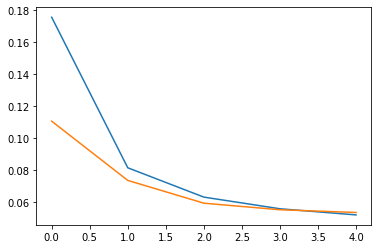

In [16]:
# Run segmentation train loop
train_losses, valid_losses = train_denoising_model(
    model,
    x_train[:100], y_train[:100],
    x_valid[:50], y_valid[:50],
    criterion, optimizer,
    n_epochs=5, batch_size=8,
    clear_mem_steps=5,
    valid_steps=1
)

plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.show()

In [17]:
# Empty GPU cache
torch.cuda.empty_cache()

In [18]:
for i in range(20):
    plt.imshow(x_train[i].cpu().detach().numpy()[0])
    plt.show()

    plt.imshow(y_train[i].cpu().detach().numpy()[0])
    plt.show()

    plt.imshow(model(torch.unsqueeze(x_train[i], dim=0)).cpu().detach().numpy()[0][0])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

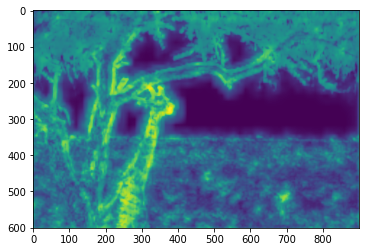

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  import sys


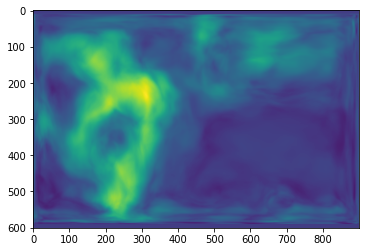

In [19]:
# 8, 9, 15, 21, 28, 29, 34, 36, 41, 44, 45, 53, 54, 61, 70
i = 8

plt.imshow(act_maps[i])
plt.show()

plt.imshow(model(torch.unsqueeze(torch.tensor(act_maps[i:i+1]).cuda(), dim=0)).cpu().detach().numpy()[0][0])
plt.show()
